# ECSE 415: Final Project
Mathieu Geoffroy, 260986559
Ryan Reszetnik, 260948454


December 5th, 2023

## Program overview
The goal of this project is to analyze dashcam video and return:
- The number of people
- The number of parked cars
- The number of moving cars
- The maximum speed of the car

This project resembles the initial ideas of the object recognition part of self-driving car software.

The project approaches this problem the following way:
1. Use YOLOv8 to detect and track objects in the video
2. Use known stationary objects to estimate the speed of the car using a moving average
3. Classify cars as parked or moving by comparing their speed to the speed of the car and use a moving average to track the car speeds
4. Use the final moving average of each car to classify them as parked or moving

In [5]:
import numpy as np
import cv2
import os
from ultralytics import YOLO
import torch
from collections import defaultdict
from matplotlib import pyplot as plt

working_dir = os.path.curdir

## Selection of the model
The YOLOv8x model was selected because it is the most recent YOLO model with several improvements of its predecessors:
- The model is more accurate and efficient
- The model includes built-in object tracking
- The model comes in a variety of sizes, from nano (n) through to extra-large (x)

The different sizes allowed for rapid testing using the nano sized model, before changing to the more precise extra large model for final performance metrics. 

In [9]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = YOLO('yolov8x.pt').to(device)

# import YOLO labels from the dataset
yolo_labels = model.names

FRAME_SIZE = (1440, 2562) # (height, width)

## Speed Estimation

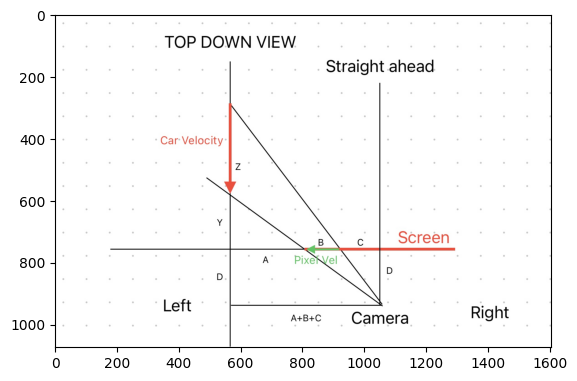

In [7]:
img = cv2.imread('image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.show(plt.imshow(img))

To calculate the speed of cars, we assume the math based on a top-down view as seen above. This assumes everything is at eye level and the same distance away from the car which is a simplification but seems to give good enough results. This means that objects like fire hydrants can be used in speed calculations, but others like traffic lights will yiled skewed results.

To derive equation used in code, we need to find Z in terms of B and C where:
C = distance from centre of screen
B = velocity of object in pixels
Z = real object velocity

From the figure above, we can see that:
(D+Y)/(A+B+C)=D/(B+C)
D+Y = (A+B+C)*D/(B+C)
Y= (A+B+C)*D/(B+C)-D

(D+Y+Z)/(A+B+C) = D/C
Y+Z=(A+B+C)*D/C-D

Subtract two equations

Z=((A+B+C)*D/C-D) - ((A+B+C)*D/(B+C)-D)

Z= (A+B+C)*D/C-(A+B+C)*D/(B+C)

Z= (A+B+C)*D*(1/C-1/(B+C))
Z= (A+B+C)*D*B/(C(B+C))

A+B+C —> can be approximated to A due to the size of the objects compared to the rest of the image

Thus, Z is approximately proportional to: A*B/(C^2+CB)

Here, we will assume A is constant, however in theory, we could get it in terms of distance.

Therefore, we use the following equation to calculate the speed of the car:
Z about proportional to: B/(C^2+CB)

## Detecting Moving vs Parked Cars

Now that we have an approximate speed for each object in the frame, we take all stationary objects and do a moving average to calculate an approximate speed (we start the speed at guess of 30 km/h as the car is moving to begin with in both videos). This is constantly updated every frame by both parked cars as well as known stationary objects like fire hydrants since they don't move and are approximately eye level. To determine if a car is parked or moving, we check the speed of the car compared to the estimated speed. If it is more than 1.5x the speed then it's classified as moving otherwise stopped. Any parked cars go into calculating the speed for the next frame (moving average based on the current estimated speed and the speed of each object in the frame). Fire hydrants hold a stronger weight as they are known to be stationary.

In [10]:
def get_actual_speed(positions):
    new_pos = []
    for i in range(len(positions)):
        new_pos.append((positions[i][0].numpy(),positions[i][1].numpy()))
    new_pos = np.array(new_pos)
    speed = []
    for j in range(len(new_pos)-1):
        speed.append(np.sqrt((new_pos[j][0]-new_pos[j+1][0])**2+(new_pos[j][1]-new_pos[j+1][1])**2))
    speed = np.array(speed)
    new_pos = 1250-new_pos[:-1,0]
    speed = speed/(new_pos**2+abs(new_pos*speed)) * 1000000
    # median filter of size 3
    median_speed = []
    median_size = 5
    if len(speed) < median_size:
        return np.mean(speed)
    for i in range(len(speed)-median_size+1):
        median_speed.append(np.median(speed[i:i+median_size]))
    median_speed = np.array(median_speed)
    return np.mean(median_speed)


def is_moving(speed,predicted_speed):
    return speed > 1.5*predicted_speed

In [11]:
# Open the video file
def analyze_video(video_path, display=True, save=True):
    print(f"Analyzing video {video_path}...")
    total_start = cv2.getTickCount()
    
    cap = cv2.VideoCapture(video_path)

    video_name = video_path.split('/')[-1].split('.')[0]

    out = cv2.VideoWriter(f'{video_name}_analyzed.mp4',cv2.VideoWriter_fourcc('m','p','4','v'), 30, (int(cap.get(3)),int(cap.get(4))))

    # Store the track history
    track_history = defaultdict(lambda: [])
    moving_history = defaultdict(lambda: [])

    people_count = 0
    predicted_speed = 30
    max_speed = 0

    # Loop through the video frames
    frame_count = 0

    while cap.isOpened():
        start = cv2.getTickCount()
        # Read a frame from the video
        success, frame = cap.read()
        frame_count += 1

        if success:
            # Run YOLOv8 tracking on the frame, persisting tracks between frames
            results = model.track(frame, persist=True,verbose=False)

            # Get the boxes, masks, track IDs, class, for the frame
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()
            classes = results[0].boxes.cls.int().cpu().tolist()
            
            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # For each object in the frame
            for box,track_id,cls in zip(boxes, track_ids,classes):
                # count the people
                if yolo_labels[cls] == 'person' and track_id not in track_history:
                    people_count += 1
                
                x, y, w, h = box
                track = track_history[track_id]
                track.append((x, y))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)
                    
                # detect if the bounding box is touching the edge of the frame   
                touching_edge =  x-w/2 <10 or x+w/2 > FRAME_SIZE[1] or y-h/2 < 0 or y+h/2 > FRAME_SIZE[0]
                
                # get the speed of the object
                obj_speed = get_actual_speed(track)
                
                # update the predicted speed for known stationary objects (to determine the speed of our car)
                if  yolo_labels[cls] == 'fire hydrant' and not np.isnan(obj_speed) and not touching_edge:
                    predicted_speed = 29/30 * predicted_speed + 1/30 * obj_speed
                    
                # set obj_speed to zero if it is Nan
                if np.isnan(obj_speed):
                    obj_speed = 0
                
                # determine if the object is moving or not
                moving_pred = is_moving(obj_speed,predicted_speed)
                
                if yolo_labels[cls] == 'car':
                    moving_history[track_id] = moving_pred
                if obj_speed > 0 and not moving_pred and not np.isnan(obj_speed) and not touching_edge:
                    predicted_speed = 59/60 * predicted_speed + 1/60 * obj_speed

                if yolo_labels[cls] == 'car':
                    text = "moving" if moving_pred else "parked"
                    cv2.putText(annotated_frame, text, (int(x-w/2), int(y+h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

            # count the number of moving and parked cars
            num_moving = 0
            num_parked = 0
            for track_id in moving_history:
                if moving_history[track_id]:
                    num_moving += 1
                else:
                    num_parked += 1
            
            # make transparent box in top left corner
            annotated_frame[0:225,0:625,:] = 0.5*annotated_frame[0:225,0:625,:] + 0.5*np.ones((225,625,3),dtype=np.uint8)
            
            
            
            # Display the number of people
            cv2.putText(annotated_frame, f"Number of people: {people_count}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the number of moving cars
            cv2.putText(annotated_frame, f"Number of moving cars: {num_moving}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the number of parked cars
            cv2.putText(annotated_frame, f"Number of parked cars: {num_parked}", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Display the predicted speed with 2 decimal places
            cv2.putText(annotated_frame, f"Approximate speed: {predicted_speed:.2f} km/h", (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            # Display the annotated frame to the user
            cv2.imshow(f'Tracking {video_name}', annotated_frame) if display else None

            # update max speed
            max_speed = max(max_speed, predicted_speed)

            # save the annotated frame to a new video
            out.write(annotated_frame) if save else None
            
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break

            end = cv2.getTickCount()
            print(f"Frame {frame_count} in {(end-start)/cv2.getTickFrequency()}s")

        else:
            # Break the loop if the end of the video is reached
            break

    # Release the video capture object and close the display window
    cap.release()
    out.release()
    cv2.destroyAllWindows()

    total_end = cv2.getTickCount()

    print(f"\n\nVideo {video_name} analyzed successfully in {(total_end-total_start)/cv2.getTickFrequency()} seconds")
    print(f"Number of people: {people_count}")
    print(f"Number of moving cars: {num_moving}")
    print(f"Number of parked cars: {num_parked}")
    print(f"Approximate max speed: {max_speed:.2f} km/h")

## McGill Video

In [12]:
analyze_video(working_dir + '/mcgill_drive.mp4', display=True, save=True)

Analyzing video ./mcgill_drive.mp4...
Frame 1 in 0.66834175s
Frame 2 in 0.160530708s
Frame 3 in 0.15885s
Frame 4 in 0.157180583s
Frame 5 in 0.157138917s
Frame 6 in 0.159309625s
Frame 7 in 0.15325125s
Frame 8 in 0.15331625s
Frame 9 in 0.15798275s
Frame 10 in 0.14969175s
Frame 11 in 0.149654292s
Frame 12 in 0.15733525s
Frame 13 in 0.146696709s
Frame 14 in 0.153306542s
Frame 15 in 0.153255291s
Frame 16 in 0.158778542s
Frame 17 in 0.155973917s
Frame 18 in 0.159638125s
Frame 19 in 0.157500208s
Frame 20 in 0.149450417s
Frame 21 in 0.150485709s
Frame 22 in 0.157173875s
Frame 23 in 0.153824833s
Frame 24 in 0.159590583s
Frame 25 in 0.15204375s
Frame 26 in 0.15969275s
Frame 27 in 0.1615005s
Frame 28 in 0.163116208s
Frame 29 in 0.161832041s
Frame 30 in 0.15541325s
Frame 31 in 0.160619875s
Frame 32 in 0.151633s
Frame 33 in 0.151851958s
Frame 34 in 0.151043125s
Frame 35 in 0.152378333s
Frame 36 in 0.15423225s
Frame 37 in 0.1487285s
Frame 38 in 0.148364541s
Frame 39 in 0.156429417s
Frame 40 in 0.154

## Sainte-Catherine Video

In [61]:
analyze_video(working_dir + '/st-catherines_drive.mp4', display=True, save=True)

Analyzing video ./st-catherines_drive.mp4...
Frame 1 in 0.236907375s
Frame 2 in 0.185530375s
Frame 3 in 0.17746025s
Frame 4 in 0.177855s
Frame 5 in 0.174190417s
Frame 6 in 0.181658916s
Frame 7 in 0.166798458s
Frame 8 in 0.176897083s
Frame 9 in 0.168816209s
Frame 10 in 0.176775792s
Frame 11 in 0.172854584s
Frame 12 in 0.171672333s
Frame 13 in 0.178690125s
Frame 14 in 0.165326583s
Frame 15 in 0.17600575s
Frame 16 in 0.175158959s
Frame 17 in 0.160764209s
Frame 18 in 0.173994917s
Frame 19 in 0.170125584s
Frame 20 in 0.17452825s
Frame 21 in 0.170711875s
Frame 22 in 0.172074333s
Frame 23 in 0.167872209s
Frame 24 in 0.166682958s
Frame 25 in 0.172863333s
Frame 26 in 0.171864917s
Frame 27 in 0.173842292s
Frame 28 in 0.177115417s
Frame 29 in 0.178362584s
Frame 30 in 0.173767084s
Frame 31 in 0.175179792s
Frame 32 in 0.184299333s
Frame 33 in 0.203233208s
Frame 34 in 0.174836417s
Frame 35 in 0.171395666s
Frame 36 in 0.178874334s
Frame 37 in 0.165187291s
Frame 38 in 0.169614542s
Frame 39 in 0.168454

## Comparison of results
### McGill Video
|             | True Value | Computed Values |
|-------------|:----------:|:---------------:|
| People      |     45     |       53        |
| Moving Cars |     28     |       29        |
| Parked Cars |     19     |       31        |  

Predicted Max Speed: 47.22 km/h

### Sainte-Catherine Video
|             | True Value | Computed Values |
|-------------|:----------:|:---------------:|
| People      |    106     |       121       |
| Moving Cars |     8      |       21        |
| Parked Cars |     58     |       66        |  

Predicted Max Speed: 73.50 km/h

### Discussion

When comparing the true values in the videos with the computed values from our code, we can see some disparity between the two. Although the computed numbers are generally similar, there is still an important difference from the truth values. 
We believe that some of the error comes from the YOLOv8 classification and tracking itself:
- The YOLOv8 model cannot tack objects when they are hidden for a few frames, this means that cars and people that fall out of view will be counted as a new car when they reappear.
- Although rare, the YOLOv8 model occasionally misclassifies objects, for example, it classified a statue as a car in the McGill video.
- Also very rare, the YOLOv8 model does occasionally identify the reflections of cars in windows as a car, which adds to the total value.

Addionally, some of the error comes from our estimation of the speed of the cars:
- Although the moving average of the car speed generally arrives at the correct conclusion, there are still cases where it misclassifies a parked car as moving or vice versa. An example of this is the main car being followed in the sainte-catherine video: it is classified as moving in the first half, but then as parked in the second half.
- The error might come from the speed estimation of the driving car, as we compare the calculated speed of the car with the calculated speed of our car (using stationary objects) to determine if the examined car is moving.
